## Propensity score matching

In this notebook, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from cache_to_disk import cache_to_disk


In [9]:
df_movie = pd.read_csv('../Datasets/movies_cleaned_dataset.csv')
df_movie.Top_genres.replace('Action/Adventure', 'Action_Adventure', inplace=True)

In [12]:
columns_causal = ['Movie_name', 'Movie_runtime', 'Main_language', 'Top_genres',
       'Main_country', 'Main_continent', 'Release_Date','averageRating', 'numVotes', 
       'Oscar_Wins', 'Nominations', 'Inflation_adjusted_profit', 'Director_name'] # columns to be used for causal inference

df_causal = df_movie[columns_causal]
df_causal = df_causal[df_causal['Inflation_adjusted_profit']>1000].reindex() # remove movies with profit less than 1000
df_causal = df_causal.dropna() # drop rows with missing values     
df_causal


,Movie_name,Movie_runtime,Main_language,Top_genres,Main_country,Main_continent,Release_Date,averageRating,numVotes,Oscar_Wins,Nominations,Inflation_adjusted_profit,Director_name
5,Henry V,137.0,English Language,Drama,United Kingdom,Europe,1989,7.5,31193.0,1,3,2.217323e+06,Kenneth Branagh
8,Mary Poppins,139.0,English Language,Family,United States of America,USA,1964,7.8,181710.0,5,13,7.348061e+08,Robert Stevenson
12,Baby Boy,123.0,English Language,Drama,United States of America,USA,2001,6.4,16026.0,0,0,1.789112e+07,John Singleton
22,The Gods Must Be Crazy,109.0,Multilingual,Action_Adventure,South Africa,Africa,1980,7.3,58570.0,0,0,8.426204e+07,Jamie Uys
24,Kinjite: Forbidden Subjects,97.0,English Language,Action_Adventure,United States of America,USA,1989,5.5,3701.0,0,0,6.525069e+06,J. Lee Thompson
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42117,Twister,113.0,English Language,Action_Adventure,United States of America,USA,1996,6.5,207675.0,0,0,6.074566e+08,Jan de Bont
42122,How to Eat Fried Worms,98.0,English Language,Family,United States of America,USA,2006,5.3,5882.0,0,0,1.531395e+07,Bob Dolman
42126,Eternally Yours,91.0,English Language,Drama,United States of America,USA,1939,5.7,825.0,0,0,1.162769e+07,Tay Garnett
42133,Coming to America,117.0,English Language,Drama,United States of America,USA,1988,7.1,218808.0,0,0,4.999682e+08,John Landis


## Exploring relationship between winning an award and profit

### Naive approach

In [13]:
awarded = df_causal[df_causal['Oscar_Wins']>0]
not_awarded = df_causal[df_causal['Oscar_Wins']==0]

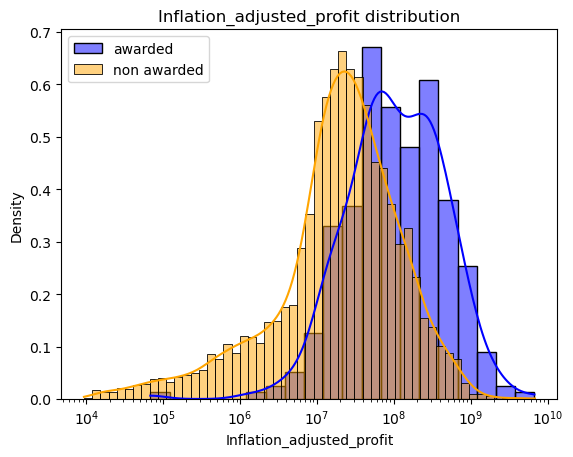

In [60]:
ax = sns.histplot(awarded['Inflation_adjusted_profit'], kde=True, stat='density', color='blue', label='awarded', log_scale=True)
ax = sns.histplot(not_awarded['Inflation_adjusted_profit'], kde=True, stat='density', color='orange', label='non awarded', log_scale=True)
ax.set(xlabel='Inflation_adjusted_profit', ylabel='Density')
plt.title('Inflation_adjusted_profit distribution')
plt.legend()
plt.show()

### Propensity score model

In [52]:
# let's standardize the continuous features

df_causal['Movie_runtime'] = (df_causal['Movie_runtime'] - df_causal['Movie_runtime'].mean())/df_causal['Movie_runtime'].std()
df_causal['averageRating'] = (df_causal['averageRating'] - df_causal['averageRating'].mean())/df_causal['averageRating'].std()
df_causal['numVotes'] = (df_causal['numVotes'] - df_causal['numVotes'].mean())/df_causal['numVotes'].std()
df_causal['Was_awarded'] = df_causal['Oscar_Wins'].apply(lambda x: 1 if x>0 else 0)

- For the moment we don't take into account the *Director_name* and *Main_country*, and *Main_language*
- Th p-values for *C(Main_language)* are all equal to 1: indeed the Oscars dataset contains only for english language movies. We delete this driver
- The p-alues are also nearly equal to 1 for all *Main_country*: so we delete this driver

In [32]:
mod = smf.logit(formula='Was_awarded ~ Movie_runtime + Release_Date + averageRating + numVotes +  C(Top_genres)', data=df_causal)

res = mod.fit()

# Extract the estimated propensity scores
df_causal['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.175976
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            Was_awarded   No. Observations:                 4276
Model:                          Logit   Df Residuals:                     4266
Method:                           MLE   Df Model:                            9
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.3324
Time:                        18:04:43   Log-Likelihood:                -752.47
converged:                       True   LL-Null:                       -1127.2
Covariance Type:            nonrobust   LLR p-value:                1.578e-155
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   46.8599      6.406      7.315      0.000      34.304

In [33]:
df_causal.head()

,Movie_name,Movie_runtime,Main_language,Top_genres,Main_country,Main_continent,Release_Date,averageRating,numVotes,Oscar_Wins,Nominations,Inflation_adjusted_profit,Director_name,Was_awarded,Propensity_score
5,Henry V,1.728416,English Language,Drama,United Kingdom,Europe,1989,1.165055,-0.263915,1,3,-0.346264,Kenneth Branagh,1,0.246697
8,Mary Poppins,1.836881,English Language,Family,United States of America,USA,1964,1.489820,0.634445,5,13,2.830084,Robert Stevenson,1,0.651698
12,Baby Boy,0.969163,English Language,Drama,United States of America,USA,2001,-0.025747,-0.354440,0,0,-0.278305,John Singleton,0,0.019766
22,The Gods Must Be Crazy,0.209909,Multilingual,Action_Adventure,South Africa,Africa,1980,0.948546,-0.100516,0,0,0.009465,Jamie Uys,0,0.106749
24,Kinjite: Forbidden Subjects,-0.440879,English Language,Action_Adventure,United States of America,USA,1989,-1.000040,-0.428001,0,0,-0.327586,J. Lee Thompson,0,0.002181


### Balancing the dataset via matching

We use the propensity scores to match each data point from the awarded group with exactly one data point from the non-awarded group, while ensuring that each data point from the awarded group is matched with at most one data point from the non-awarded group.

For this task, we implement the simplest, full optimal matching, and analyse the results.

In order to perform matching between pairs, a distance/similarity function is needed. Since the library used for the matching (networkx) has a function that maximizes the sum of weights between pairs, it is natural to use a function that measures similarity.

Wanting to minimize the difference of propensity scores between pairs, we define the similarity function between two instances $x$ and $y$ like:

$$ similarity(x,y) = 1 - | propensity\_score(x) - propensity\_score(y) |$$
This function captures the difference in scores like a distance, but since the distance defined like that would always be between 0 and 1, subtracting it from 1 would be a meaningful measure to use for similarity.

In [34]:
@cache_to_disk(1)
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [35]:
# Separate the treatment and control groups
awarded = df_causal[df_causal['Was_awarded'] == 1]
non_awarded = df_causal[df_causal['Was_awarded'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in non_awarded.iterrows():
    for treatment_id, treatment_row in awarded.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [36]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [58]:
balanced_df_1 = df_causal.loc[matched]

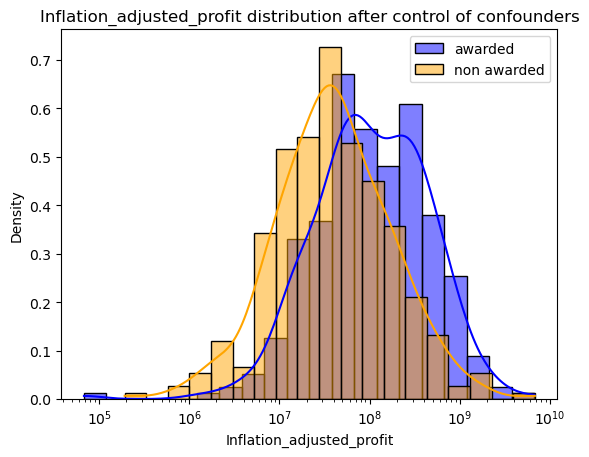

In [59]:
awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==1]
not_awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==0]

ax = sns.histplot(awarded_2['Inflation_adjusted_profit'], kde=True, stat='density', color='blue', label='awarded', log_scale=True)
ax = sns.histplot(not_awarded_2['Inflation_adjusted_profit'], kde=True, stat='density', color='orange', label='non awarded', log_scale=True)
ax.set(xlabel='Inflation_adjusted_profit', ylabel='Density')
plt.title('Inflation_adjusted_profit distribution after control of confounders')
plt.legend()
plt.show()

**Comments:**
- The plot after control of coufonder seems to show less evidence of a significantly higher profit for awarded movies compared to non awarded.
- This suggests that there is a correlation link between the cofounders and the movie profits
    - The IMBD has a clean correlation with the profit and with the fact of beeing awarded or not.
    - The release date may also have a link with the inflation adapted profit. We might argue that the movie industry was smaller back then

**Test to be made:**
- Test mean is equal for awarded and non-awarded profit after control

In [65]:
# statistical test to check if the difference in profit between awarded and non awarded movies is significant

from scipy.stats import ttest_ind
awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==1]
not_awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==0]
print(ttest_ind(awarded_2['Inflation_adjusted_profit'], not_awarded_2['Inflation_adjusted_profit'])) 

TtestResult(statistic=3.5209307162352554, pvalue=0.00046107971551524507, df=630.0)


The statistical test comparing the inflation-adjusted profits between awarded and non-awarded movies yields a significant result (p-value = 0.00046). This suggests that there is a statistically significant difference in profits between movies that have received awards and those that have not.

In [66]:
# let's check if the difference in profit between awarded and non awarded movies is significant for each genre
for genre in df_causal.Top_genres.unique():
    awarded_2 = balanced_df_1[(balanced_df_1['Was_awarded']==1) & (balanced_df_1['Top_genres']==genre)]
    not_awarded_2 = balanced_df_1[(balanced_df_1['Was_awarded']==0) & (balanced_df_1['Top_genres']==genre)]
    print(genre, ttest_ind(awarded_2['Inflation_adjusted_profit'], not_awarded_2['Inflation_adjusted_profit']))

Drama TtestResult(statistic=4.164437242393042, pvalue=3.887438932180826e-05, df=370.0)
Family TtestResult(statistic=-0.2926187054113165, pvalue=0.7702468493084247, df=140.0)
Action_Adventure TtestResult(statistic=3.1385674367550562, pvalue=0.0024851659231341027, df=70.0)
Fiction TtestResult(statistic=-0.30153876746624225, pvalue=0.7657131922510296, df=23.0)
Horror TtestResult(statistic=1.160434463382617, pvalue=0.2793278614478271, df=8.0)
Other TtestResult(statistic=0.79421490754572, pvalue=0.4475051184712392, df=9.0)


**Difference in Profit by Genre:**

- Drama: There is a significant difference in profits between awarded and non-awarded Drama movies (p-value = 3.89e-05). Awarded Drama movies tend to have significantly higher profits compared to non-awarded ones.
- Family: The difference in profits between awarded and non-awarded Family movies is not statistically significant (p-value = 0.77). This implies that, within the Family genre, receiving awards does not seem to be associated with a significant difference in profits.
- Action/Adventure: Awarded Action/Adventure movies show a significant difference in profits compared to their non-awarded counterparts (p-value = 0.0025). This suggests that, within the Action/Adventure genre, receiving awards is associated with a statistically significant difference in profits.
- Fiction, Horror, Other: The differences in profits for awarded and non-awarded movies within these genres are not statistically significant. This implies that, for Fiction, Horror, and Other genres, there is insufficient evidence to conclude a significant difference in profits based on awards.

## Exploring relationship between beeing awarded and the IMBD rating of the movie

### Naive approach

In [57]:
columns_causal = ['Movie_name', 'Movie_runtime', 'Main_language', 'Top_genres',
       'Main_country', 'Main_continent', 'Release_Date','averageRating', 'numVotes', 
       'Oscar_Wins', 'Nominations', 'Inflation_adjusted_profit', 'Director_name'] # columns to be used for causal inference

df_causal = df_movie[columns_causal]
df_causal = df_causal[df_causal['Inflation_adjusted_profit']>1000].reindex() # remove movies with profit less than 1000
df_causal['Was_awarded'] = df_causal['Oscar_Wins'].apply(lambda x: 1 if x>0 else 0)
df_causal = df_causal.dropna() # drop rows with missing values     
df_causal.head()

,Movie_name,Movie_runtime,Main_language,Top_genres,Main_country,Main_continent,Release_Date,averageRating,numVotes,Oscar_Wins,Nominations,Inflation_adjusted_profit,Director_name,Was_awarded
5,Henry V,137.0,English Language,Drama,United Kingdom,Europe,1989,7.5,31193.0,1,3,2.217323e+06,Kenneth Branagh,1
8,Mary Poppins,139.0,English Language,Family,United States of America,USA,1964,7.8,181710.0,5,13,7.348061e+08,Robert Stevenson,1
12,Baby Boy,123.0,English Language,Drama,United States of America,USA,2001,6.4,16026.0,0,0,1.789112e+07,John Singleton,0
22,The Gods Must Be Crazy,109.0,Multilingual,Action_Adventure,South Africa,Africa,1980,7.3,58570.0,0,0,8.426204e+07,Jamie Uys,0
24,Kinjite: Forbidden Subjects,97.0,English Language,Action_Adventure,United States of America,USA,1989,5.5,3701.0,0,0,6.525069e+06,J. Lee Thompson,0


In [48]:
awarded = df_causal[df_causal['Oscar_Wins']>0]
not_awarded = df_causal[df_causal['Oscar_Wins']==0]

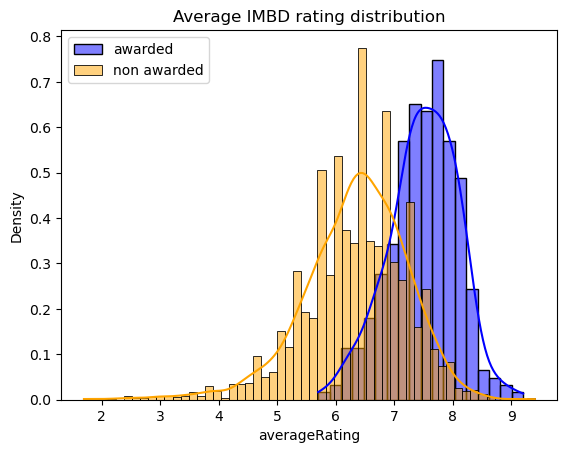

In [51]:
ax = sns.histplot(awarded['averageRating'], kde=True, stat='density', color='blue', label='awarded', log_scale=False)
ax = sns.histplot(not_awarded['averageRating'], kde=True, stat='density', color='orange', label='non awarded', log_scale=False)
ax.set(xlabel='averageRating', ylabel='Density')
plt.title('Average IMBD rating distribution')
plt.legend()
plt.show()

### Propensity score model

In [67]:
# let's standardize the continuous features

df_causal['Movie_runtime'] = (df_causal['Movie_runtime'] - df_causal['Movie_runtime'].mean())/df_causal['Movie_runtime'].std()
df_causal['numVotes'] = (df_causal['numVotes'] - df_causal['numVotes'].mean())/df_causal['numVotes'].std()
df_causal['Inflation_adjusted_profit'] = (df_causal['Inflation_adjusted_profit'] - df_causal['Inflation_adjusted_profit'].mean())/df_causal['Inflation_adjusted_profit'].std()

- For the moment we don't take into account the *Director_name* and *Main_country*, and *Main_language*
- Th p-values for *C(Main_language)* are all equal to 1: indeed the Oscars dataset contains only for english language movies. We delete this driver
- The p-alues are also nearly equal to 1 for all *Main_country*: so we delete this driver

In [68]:
mod = smf.logit(formula='Was_awarded ~ Movie_runtime + Release_Date + Inflation_adjusted_profit + numVotes +  C(Top_genres)', data=df_causal)

res = mod.fit()

# Extract the estimated propensity scores
df_causal['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.203257
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Was_awarded   No. Observations:                 4276
Model:                          Logit   Df Residuals:                     4266
Method:                           MLE   Df Model:                            9
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.2290
Time:                        18:35:34   Log-Likelihood:                -869.13
converged:                       True   LL-Null:                       -1127.2
Covariance Type:            nonrobust   LLR p-value:                1.974e-105
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    78.2124      6.034     12.963      0.000      66.

### Computing propensity scores

In [74]:
# Separate the treatment and control groups
awarded = df_causal[df_causal['Was_awarded'] == 1]
non_awarded = df_causal[df_causal['Was_awarded'] == 0]

# Create an empty undirected graph
G2 = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in non_awarded.iterrows():
    for treatment_id, treatment_row in awarded.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G2.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G2)

In [75]:
matched2 = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df_2 = df_causal.loc[matched2]

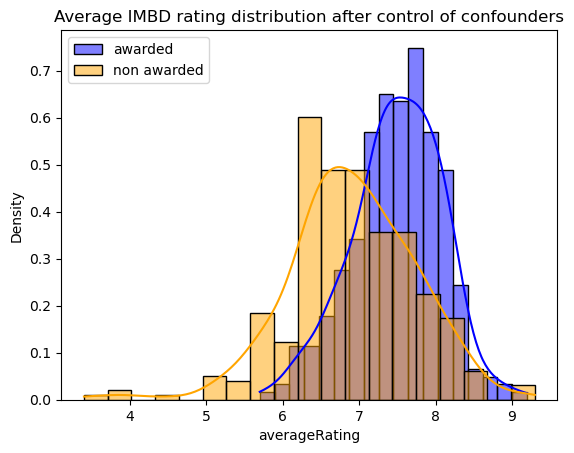

In [78]:
awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==1]
not_awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==0]

ax = sns.histplot(awarded_3['averageRating'], kde=True, stat='density', color='blue', label='awarded', log_scale=False)
ax = sns.histplot(not_awarded_3['averageRating'], kde=True, stat='density', color='orange', label='non awarded', log_scale=False)
ax.set(xlabel='averageRating', ylabel='Density')
plt.title('Average IMBD rating distribution after control of confounders')
plt.legend()
plt.show()

In [79]:
# statistical test to check if the difference in IMBD rating between awarded and non awarded movies is significant

from scipy.stats import ttest_ind
awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==1]
not_awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==0]
print(ttest_ind(awarded_3['averageRating'], not_awarded_3['averageRating'])) 

TtestResult(statistic=10.175456667055386, pvalue=1.2792665695538858e-22, df=630.0)


In [80]:
# let's check if the difference in IMBD rating between awarded and non awarded movies is significant for each genre
for genre in df_causal.Top_genres.unique():
    awarded_3 = balanced_df_2[(balanced_df_2['Was_awarded']==1) & (balanced_df_2['Top_genres']==genre)]
    not_awarded_3 = balanced_df_2[(balanced_df_2['Was_awarded']==0) & (balanced_df_2['Top_genres']==genre)]
    print(genre, ttest_ind(awarded_3['averageRating'], not_awarded_3['averageRating']))

Drama TtestResult(statistic=8.226459644059743, pvalue=3.412944919704113e-15, df=366.0)
Family TtestResult(statistic=5.371259923414913, pvalue=3.09388227870342e-07, df=143.0)
Action_Adventure TtestResult(statistic=3.2693918068811536, pvalue=0.0016829009395072589, df=69.0)
Fiction TtestResult(statistic=0.39610678227782137, pvalue=0.6964393230790848, df=19.0)
Horror TtestResult(statistic=1.749612823825816, pvalue=0.11411321021251909, df=9.0)
Other TtestResult(statistic=2.0477863301025647, pvalue=0.05982210429364817, df=14.0)


## Exploring relationship between beeing awarded and having a well-known producer

In [ ]:
df_causal.Director_name.value_counts()

Director_name
Woody Allen             19
Steven Spielberg        19
Clint Eastwood          18
Alfred Hitchcock        17
George Cukor            16
                        ..
Im Kyung-soo             1
Dennis Gansel            1
Alan Poul                1
Robert C. Ramirez        1
Patrick Read Johnson     1
Name: count, Length: 2075, dtype: int64

In [ ]:
df_awarded = df_causal[df_causal['Oscar_Wins']>0] # movies with at least one oscar

In [ ]:
df_directors = df_awarded.Director_name.value_counts()
df_directors